# 1 - Exploración del conjunto de datos.
Este *notebook* está dedicado a la exploración inicial del conjunto de datos. Se analiza su estructura, se visualizan las muestras y se extraen estadísticas básicas que justificarán las acciones de preprocesado posteriores. También se analizan los datos demográficos de los participantes del estudio.

El conjunto de datos empleado proviene del estudio de Bezmaternykh et al. (2021) titulado *Brain Networks Connectivity in Mild to Moderate Depression: Resting State fMRI Study with Implications to Nonpharmacological Treatment*. Los datos se tratan de imágenes de resonancia magnética funcional (RMf) en reposo adquiridas con un escáner Philips Ingenia 3T utilizando una secuencia de imágenes ecoplanares con los siguientes parámetros: tamaño de vóxel = 2x2x5 mm, tiempo de repetición = 2500ms, tiempo de eco = 35 ms, 25 cortes por volumen y un total de 100 volúmenes por participante. Los datos se encuentran en formato NIfTI (.nii.gz) y se distribuyen en acceso abierto junto con un archivo que contiene información demográfica y clínica de los participantes. En este repositorio los datos de RMf se encuentran en el directorio */data/raw* y los datos demográficos se encuentran en el archivo */data/paticipants.tsv*.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/data"

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set()

## 1.1 - Exploración de los datos de RMf.
En este apartado examina el formato de los datos y se realiza una inspección estadística y visual de la señal BOLD.

### 1.1.1 - Exploración de la estructura y formato de los datos de RMf.

In [ ]:
raw_data_path = os.path.join(data_path, "raw")
files = os.listdir(raw_data_path)
print(f"Total archivos: {len(files)}")
print("Ejemplo de nombre de los archivos:", files[:3])

Total archivos: 72
Ejemplo de nombre de los archivos: ['sub-50_bold.nii.gz', 'sub-51_bold.nii.gz', 'sub-52_bold.nii.gz']


La muestra está compuesta por los datos de RMf de 72 participantes, incluyendo pacientes diagnosticados con depresión leve o moderada y controles sanos.

In [ ]:
example_file = os.path.join(raw_data_path, files[0])
img = nib.load(example_file)
data = img.get_fdata()

print(f"Forma de los datos: {data.shape}")
print(f"Tipo de datos: {data.dtype}")

Forma de los datos: (112, 112, 25, 100)
Tipo de datos: float64


Cada muestra es un dato 4D con la siguiente estructura [x, y, z, t]. Donde:
- *x*: tamaño del eje X (ancho de la imagen de RMf).
- *y*: tamaño del eje y (alto de la imagen de RMf).
- *z*: número de cortes axiales.
- *t*: número de volúmenes temporales.

Como se ha indicado anteriormente, los datos de RMf de cada participante se componen de una secuencia de 100 volúmenes 3D compuestos por 25 cortes axiales del cerebro con un tamaño de 112x112 píxeles. Además, el tipo de dato es *float64*, el cual es altamente preciso y tiene poca compresión.

### 1.1.2 - Evolución de la señal BOLD media a lo largo del tiempo.

Se calcula la media de intensidades BOLD por volumen temporal, promediando todos los vóxeles del volumen en cada instante. De esta manera se obtiene una curva que permite observar la estabilidad global de la señal. Esta práctica es común en estudios de control de calidad de MRf para detectar artefactos de movimiento o errores en la adquisición (Power et al., 2012).

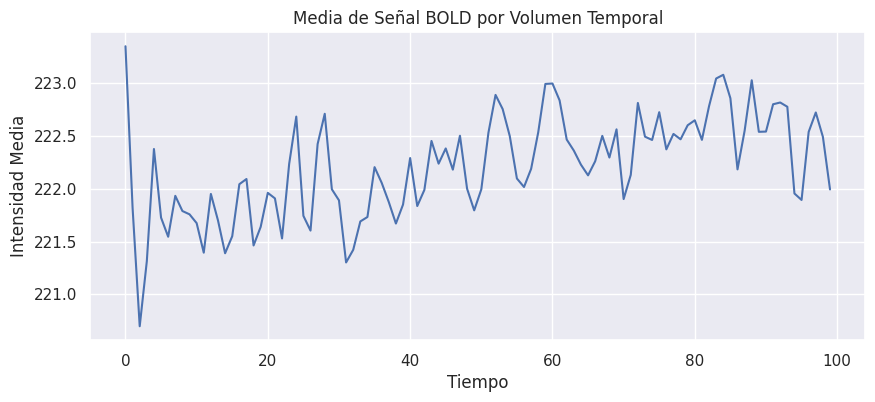

In [ ]:
time_points = data.shape[3]
mean_signal = [np.mean(data[:, :, :, t]) for t in range(time_points)]

plt.figure(figsize=(10, 4))
plt.plot(mean_signal)
plt.title("Media de Señal BOLD por Volumen Temporal")
plt.xlabel("Tiempo")
plt.ylabel("Intensidad Media")
plt.grid(True)
plt.show()

Como se puede observar, la media oscila en un rago estrecho (221-223) y no hay grandes oscilaciones, lo cual indica una buena estabilidad global. Además, salvo en el caso de los primeros pasos temporales, no hay saltos abruptos o caídas dramáticas que indiquen errores de adquisición graves.

### 1.1.3 - Rango de intensidades.
En línea con prácticas habituales de inspección previa en *pipelines* como *fMRIPrep* (Esteban et al., 2019), se evalua el rango dinámico de los datos extrayendo el valor mínimo y máximo del primer volumen funcional y su histograma de intensidades. Este análisis permite comprobar si los datos contienen valores fuera de lo esperable (ruido de fondo o regiones sin señal).

Rango de intensidades: 0.00 a 2648.35



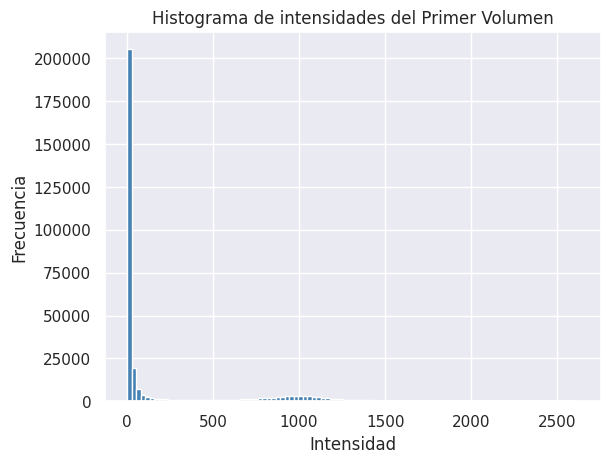

In [ ]:
min_val, max_val = np.min(data), np.max(data)
print(f"Rango de intensidades: {min_val:.2f} a {max_val:.2f}\n")

plt.hist(data[:, :, :, 0].ravel(), bins=100, color='steelblue')
plt.title("Histograma de intensidades del Primer Volumen")
plt.xlabel("Intensidad")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

El rango de intensidades es 0.00-2648.35. La forma del histograma muestra un pico muy pronunciado a cerca de 0 y un pequeño grupo de valores alrededor de 1000. Esto indica que la mayoría de los vóxeles no contienen señal útil (aire, fondo). También se observa una concentración en el rango 750-1250, probablemente correspondiente al cerebro.

A continuación se visualizará el histograma de intensidades de este rango en específico.

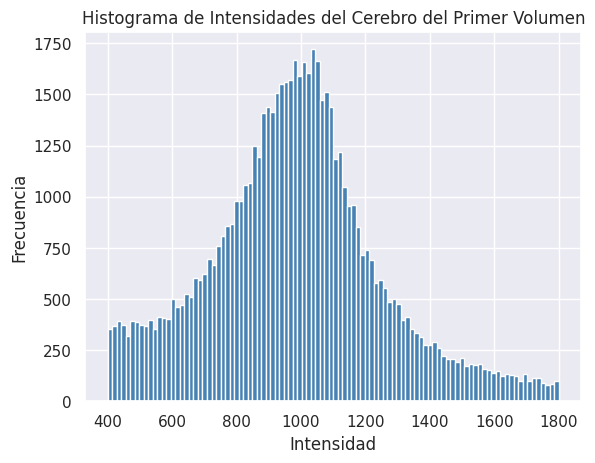

In [ ]:
plt.hist(data[:, :, :, 0].ravel(), bins=100, color='steelblue', range=(400, 1800))
plt.title("Histograma de Intensidades del Cerebro del Primer Volumen")
plt.xlabel("Intensidad")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

Como se puede observar este rango de intensidades muestra una frecuencia con una distribución más simétrica, correspondiente a los vóxeles cerebrales.

### 1.1.4 - Visualización de cortes axiales en el tiempo.

Se extraen cinco imágenes correspondientes al mismo corte axial central  en diferentes pasos temporales. Esta visualización permite inspeccionar visualmente la coherencia estructural del cerebro a lo largo del tiempo y verificar que no existen desplazamientos bruscos u otros artefactos. Esta técnica es una extensión visual de las gráficas obtenidas anteriormente.

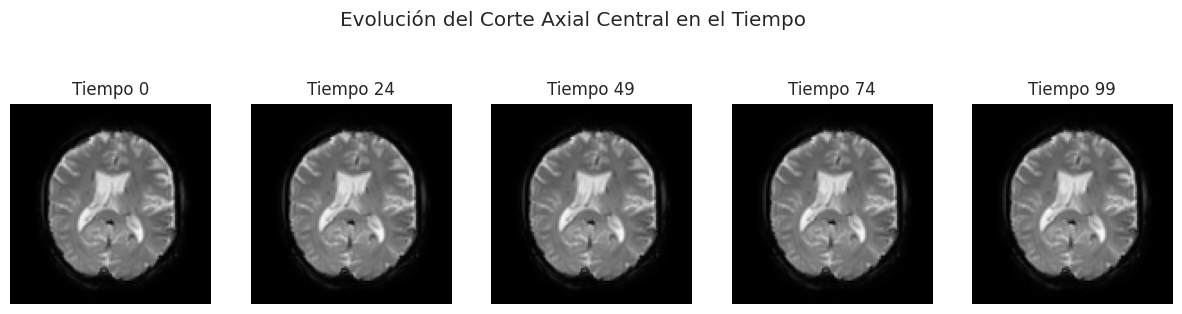

In [ ]:
slice_index = data.shape[2] // 2

fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for i, t in enumerate(np.linspace(0, time_points-1, 5, dtype=int)):
    axes[i].imshow(data[:, :, slice_index, t].T, cmap="gray", origin="lower")
    axes[i].set_title(f"Tiempo {t}")
    axes[i].axis("off")
plt.suptitle("Evolución del Corte Axial Central en el Tiempo")
plt.show()

Se observan 5 imágenes de la misma sección del cerebro (el corte Z central), tomadas en diferentes momentos durante la adquisición (reposo). Estas imágenes permiten observar fluctuaciones en la intensidad BOLD, zonas activas/inactivas según la vascularización y posibles artefactos o ruido temporal.

In [ ]:
output_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/data/visualizations"

slice_index = data.shape[2] // 2
time_points = data.shape[3]
selected_times = np.linspace(0, time_points - 1, 5, dtype=int)

for i, t in enumerate(selected_times, 1):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(data[:, :, slice_index, t].T, cmap="gray", origin="lower")
    ax.axis("off")

    filename = os.path.join(output_dir, f"axial_example_t{i}.png")
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

## 1.2 - Exploración de los datos demográficos de los participantes.
En este apartado se examina la información demográfica de los participantes que formaron parte del estudio.

### 1.2.1 - Atributos del dataset *participants.tsv*.

In [ ]:
tsv_path = os.path.join(data_path, "../participants.tsv")

descriptive_df = pd.read_csv(tsv_path, sep='\t')
print("Dimensiones del archivo .tsv:", descriptive_df.shape)
descriptive_df.head()

Dimensiones del archivo .tsv: (72, 20)


,participant_id,age,gender,group,IQ_Raven,ICD-10,MADRS,Zung_SDS,BDI,HADS-anx,HADS-depr,MC-SDS,TAS-26,ECR-avoid,ECR-anx,RRS-sum,RRS-reflection,RRS-brooding,RRS-depr,Edinburgh
0,sub-01,39,m,depr,113.0,F32.0,NaN,43.0,17.0,NaN,NaN,9.0,81.0,66.0,60.0,53.0,12.0,14.0,27.0,NaN
1,sub-02,50,m,depr,80.0,F32.0,NaN,47.0,10.0,NaN,NaN,15.0,54.0,62.0,78.0,59.0,14.0,12.0,33.0,NaN
2,sub-03,47,f,depr,87.0,F32.0,NaN,44.0,19.0,NaN,NaN,15.0,80.0,42.0,54.0,47.0,11.0,9.0,27.0,NaN
3,sub-04,32,f,depr,100.0,F32.0,NaN,34.0,6.0,NaN,NaN,10.0,71.0,42.0,39.0,37.0,9.0,9.0,19.0,NaN
4,sub-05,26,f,depr,104.0,F32.0,NaN,48.0,17.0,NaN,NaN,10.0,65.0,52.0,68.0,61.0,14.0,13.0,34.0,NaN


El archivo *participants.tsv* incluye información descriptiva de cada participante (72) y de las diferentés métricas clínicas utilizadas para el diagnóstico, un total de 20 atributos. Entre estas variables clínicas se encuentran varias escalas psicométricas utilizadas para evaluar la sintomatología depresiva y otros factores psicológicos relevantes como la Montgomery-Asberg Depression Rating Scale o el Beck Depression Inventory, entre otros. Estas métricas permiten caracterizar la severidad del cuadro clínico y complementar la interpretación de los datos neurofuncionales. Para el presente proyecto los únicos atributos utilizados son *participant_id*, *age*, *gender*    y *group*

### 1.2.2 - Distribución por tipo de diagnóstico, edad y género.

<ipython-input-4-37183e691c1b>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(["Paciente MDD", "Control Sano"])
<ipython-input-4-37183e691c1b>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(["Masculino", "Femenino"])
<ipython-input-4-37183e691c1b>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(["Paciente MDD", "Control Sano"])


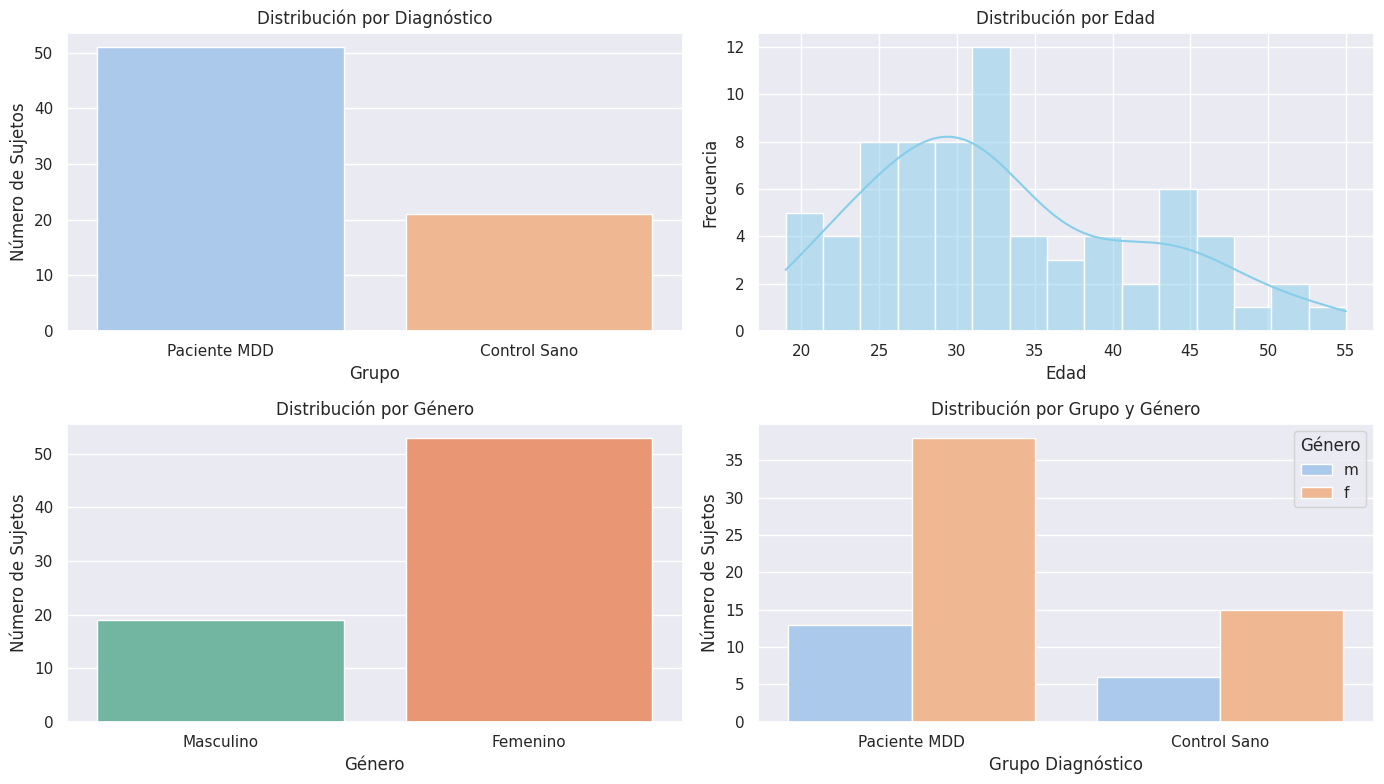

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

sns.countplot(data=descriptive_df, x='group', hue='group', ax=axes[0, 0], palette='pastel', legend=False)
axes[0, 0].set_title("Distribución por Diagnóstico")
axes[0, 0].set_xlabel("Grupo")
axes[0, 0].set_ylabel("Número de Sujetos")
axes[0, 0].set_xticklabels(["Paciente MDD", "Control Sano"])

sns.histplot(descriptive_df['age'], bins=15, kde=True, ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title("Distribución por Edad")
axes[0, 1].set_xlabel("Edad")
axes[0, 1].set_ylabel("Frecuencia")

sns.countplot(data=descriptive_df, x='gender', hue='gender', ax=axes[1, 0], palette='Set2', legend=False)
axes[1, 0].set_title("Distribución por Género")
axes[1, 0].set_xlabel("Género")
axes[1, 0].set_ylabel("Número de Sujetos")
axes[1, 0].set_xticklabels(["Masculino", "Femenino"])

sns.countplot(data=descriptive_df, x='group', hue='gender', ax=axes[1, 1], palette='pastel')
axes[1, 1].set_title("Distribución por Grupo y Género")
axes[1, 1].set_xlabel("Grupo Diagnóstico")
axes[1, 1].set_ylabel("Número de Sujetos")
axes[1, 1].legend(title="Género")
axes[1, 1].set_xticklabels(["Paciente MDD", "Control Sano"])

plt.tight_layout()
plt.show()

In [ ]:
summary = descriptive_df.groupby(['group', 'gender']).size().unstack(fill_value=0)

output_path = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)/data/visualizations/group_gender_distribution.csv"
summary.to_csv(output_path)

En las gráficas obtenidas se puede observar que:
- La mayoría de los datos pertenecen a pacientes con depresión (51), frente a los 21 controles sanos.
- La mayoría de los pacientes se encuentran en el rango de edad 25-32. Es decir, es un grupo de pacientes jóvenes.
- La mayoría de los participantes pertenecen al sexo biológico femenino (54), frente a 18 pertenecientes al sexo biológico masculino.

Es primordial tener en cuenta estos resultados debido a que el cerebro humano presenta pequeñas diferencias intersexuales. Entonces, un modelo entrenado con datos desbalanceados según el sexo biológico podría mostrar sesgos.

## Conclusión.

El análisis exploratorio llevado a cabo ha permitido examinar algunas de las tareas de preprocesado que es necesario implementar:

- Los datos se encuentran en formato *float64*. Dado que el presente proyecto presenta una serie de limitaciones temporales y computacionales, este será modificado por *float32*. Esto se debe a que *float32* suele ser más rápido en términos de computación y uso de memoria. Además, la mayoría de las operaciones de TensorFlow están optimizadas para float32 (Quora, 2024).

- La señal BOLD media de los primeros pasos temporales muestra una caída abrupta que luego se estabiliza, esto puede deberse a que durante estos primeros pasos temporales la máquina todavía se está estabilizando o que el participante está acomodándose. Por esta razón se eliminarán los volúmenes correspondientes a los primeros pasos temporales.

- El histograma de intensidades y las visualizaciones cerebrales obtenidas han permitido observar que existe un grán número de vóxeles que no contienen información cerebral. Por está razón se aplicará una máscara cerebral que aisle el cerebro en las imágenes.

- Existe una desproporción en cuanto al número de pacientes identificados con el sexo biológico masculino y femenino. Aunque el tamaño del conjunto de datos no permite excluir casos por balance, esta desigualdad será tenida en cuenta al interpretar y comunicar los resultados.

## Referencias.
Bezmaternykh, D.D., Melnikov, M.Y., Savelov, A.A., Kozlova, L.I., Petrovskiy, E.D., Natarova, K.A. and Shtark, M.B., (2021) *Brain networks connectivity in mild to moderate depression: resting state fMRI study with implications to nonpharmacological treatment*. Neural plasticity, 2021(1), p.8846097. Disponible en: https://onlinelibrary.wiley.com/doi/10.1155/2021/8846097

Esteban, O., et al. (2019). *fMRIPrep: a robust preprocessing pipeline for functional MRI*. Nature Methods, 16(1), 111-116. Disponible en: https://www.nature.com/articles/s41592-018-0235-4

Power, J. D., et al. (2012). *Spurious but systematic correlations in functional connectivity MRI networks arise from subject motion. NeuroImage*, 59(3), 2142-2154. Disponible en: https://www.sciencedirect.com/science/article/pii/S1053811911011815

Quora (2024) *When should I use tf.float32 vs tf.float64 in TensorFlow?*. Disponible en: https://www.quora.com/When-should-I-use-tf-float32-vs-tf-float64-in-TensorFlow

In [1]:
!pip freeze > requirements.txt